In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.special import legendre
from classy import Class
from fftlog import FFTLog, MPC

In [2]:
font = {'size': 14}
axislabelfontsize='large'
matplotlib.rc('font', **font)

Let us compute the multipoles $l$ of the linear power spectrum in redshift space with mask and wide-angle corrections up to order $n=2$ for $l=0,2,4$:

\begin{align}
P_l(k) & = \sum_n \int dp \ p^{2-n} \sum_{l'} W^{(n)}_{l,l'}(k,p) P^{(n)}_{l'}(p) \\
& = \sum_{l'\in\{0,2,4\}} \int dp \ p^{2} \ W^{(n)}_{l,l'}(k,p) P^{(0)}_{l'}(p) \\
& + \sum_{l'\in\{1,3\}} \int dp \ p \ W^{(1)}_{l,l'}(k,p) P^{(1)}_{l'}(p) \\
& + \sum_{l'\in\{0,2,4\}} \int dp \ W^{(2)}_{l,l'}(k,p) P^{(2)}_{l'}(p)
\end{align}

The unwindowed power spectrum ($n=0$) or the wide-angle corrections ($n>0$) read:
\begin{equation}
P_\ell^{(n)}(k) = 4\pi (-i)^\ell \int ds \ s^2 (k s)^n j_\ell(ks) \ \xi_\ell^{(n)}(s)
\end{equation}
where
\begin{equation}
\xi_\ell^{(n)}(s) = \sum_{\ell'} A^{(n)}_{\ell,\ell'} \Xi_{\ell'}^{(0)}(s) \ , \quad \Xi^{(0)}_{\ell'}(s) = \frac{1}{2 \pi^2} \int dk \ k^2 j_{\ell'}(k's) P_{11}(k') \ .
\end{equation}

Using the FFTLog decomposition of the linear power spectrum, $P_{11}(k) = \sum_j c_j \ k^{-2\nu_j}$, we get:

\begin{equation}
P_\ell^{(n)}(k) = (-i)^\ell \sum_{\ell'} A^{(n)}_{\ell,\ell'} \  \mathcal{P}_{\ell,\ell'}^{(n)}(k)
\end{equation}
where we have defined:
\begin{equation}
\mathcal{P}_{\ell,\ell'}^{(n)}(k) = \sum_{j} M^{(n)}_{\ell,\ell'}(\nu_j) \  c_j \ k^{-2\nu_j} \ , \qquad M^{(n)}_{\ell,\ell'}(\nu) \equiv  (2\pi)^3  \tilde M_{\ell}(3/2-n/2-\nu) \tilde M_{\ell'}(\nu) \ , \qquad \tilde M_\ell(\nu) = \frac{2^{-2\nu}}{\pi^{3/2}} \frac{\Gamma(3/2 + \ell/2 - \nu)}{\Gamma(\ell/2 + \nu)} \ .
\end{equation}

All in all,

\begin{align}
P_l(k) & = \sum_{n,\ell,\ell'} (-i)^\ell A^{(n)}_{\ell,\ell'} \int dp \ p^{2-n} \ W^{(n)}_{l,\ell}(k,p) \ \mathcal{P}_{\ell,\ell'}^{(n)}(p) \\
& = \sum_{\ell \in\{0,2,4\}} \int dp \ p^{2} \ W^{(0)}_{l,\ell}(k,p) \Big|_{R} \ P_{\ell}^{(0)}(p) \\
& + \sum_{\ell \in\{1,3\}, \ell' \in\{0,2,4\}} A^{(1)}_{\ell,\ell'}  \int dp \ p \ W^{(1)}_{l,\ell}(k,p) \Big|_{I} \  \mathcal{P}_{\ell,\ell'}^{(n)}(p) \\
& + \sum_{\ell,\ell' \in\{0,2,4\}} A^{(2)}_{\ell,\ell'} \int dp \ W^{(2)}_{l,\ell}(k,p) \Big|_{R} \ \mathcal{P}_{\ell,\ell'}^{(n)}(p) \ ,
\end{align}

where $\cdot |_R$ and $\cdot |_I$ stand for real and imaginary parts, respectively, and we have redefined: $A^{(2)}_{\ell,\ell'} \rightarrow (-1)^{\ell/2} A^{(2)}_{\ell,\ell'} \ $. 

Configure $k$ and $p$: should be same as in Qk_to_Wkkp notebook

In [3]:
# this array should corresponds to the k-bins of the power spectrum data
k_data = np.arange(0.005, 0.40, 0.01)
# thin k and p on which we compute W_{l,l'}(k, p).
k_arr = np.concatenate([[1e-4, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175], np.arange(0.02, 0.41, 5e-3) ])
p_arr = np.concatenate([ np.geomspace(1e-4, 0.003, 20, endpoint=False) , np.arange(0.003, 0.7, 5e-4) ])
deltap = p_arr[1:] - p_arr[:-1]
deltap = np.concatenate([[0], deltap])
print (k_data.shape, k_arr.shape, p_arr.shape)


(40,) (89,) (1414,)


Loading classy

In [4]:
z, red, sky = 0.32, "lowz", "sgc"
# z, red, sky = 0.32, "lowz", "ngc"
# z, red, sky = 0.57, "cmass", "sgc"
# z, red, sky = 0.57, "cmass", "ngc"

In [5]:
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.6777, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': z})
M.compute()

In [6]:
# linear bias, growth rate, and comoving distance [Mpc/h] to the survey (this last is put for indication)
b1, f1, d = 2., M.scale_independent_growth_factor_f(z), M.angular_distance(z) * (1+z) / M.h()
print ('Mean comoving distance to the survey: %.0f [Mpc/h]' % d)

Mean comoving distance to the survey: 1927 [Mpc/h]


In [7]:
p11 = np.array([M.pk_lin(p*M.h(), z)*M.h()**3 for p in p_arr]) 
ip11 = interp1d(p_arr, p11, kind='cubic')

# kk = np.logspace(-5, 1, 200)
# p11 = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) 
# ip11 = interp1d(kk, p11, kind='cubic')

Loading windows $W^{(n)}_{l,l'}$

In [8]:
def load_file(filename):
    ff = np.load(os.path.join('Wlmkp', filename))
    p_arr, Wlm_c, Wlm_cic, Wlm_cic_bin = ff['p'], ff['Wlm_c'], ff['Wlm_cic'], ff['Wlm_cic_bin']
    return Wlm_c, Wlm_cic, Wlm_cic_bin

Wlm_c, Wlm_cic, Wlm_cic_bin = [], [], []
for nwide in [0,1,2]:
    filename = 'Wlmkp_n%s_boss_%s_%s.npz' % (nwide, red, sky)
    Wlm_c_n, Wlm_cic_n, Wlm_cic_bin_n = load_file(filename)
    Wlm_c.append(Wlm_c_n); Wlm_cic.append(Wlm_cic_n); Wlm_cic_bin.append(Wlm_cic_bin_n)

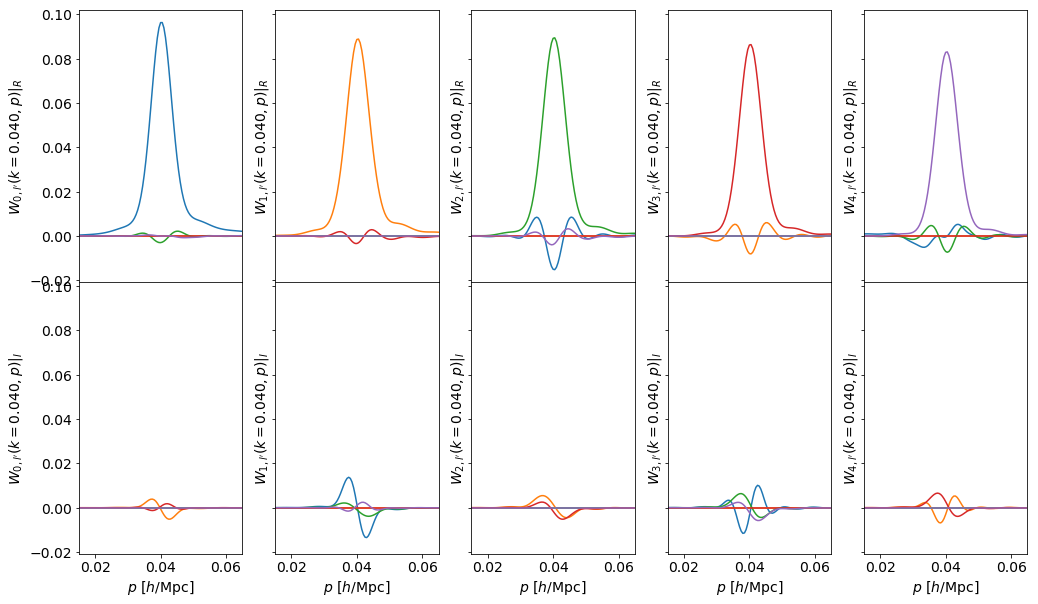

In [55]:
n = 1 # wide-angle expansion order to plot

fig, ax = plt.subplots(2,5, figsize=(17, 10), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.)

idk = 15
for l in range(5):
    for m in range(5):
        ax[0,l].plot(p_arr, np.real(Wlm_cic[n][l,m,idk]) * p_arr**2)
        ax[1,l].plot(p_arr, np.imag(Wlm_cic[n][l,m,idk]) * p_arr**2)
    for i in range(2):
        # ax[i,l].set_xlim(1e-4, 1e-1)
        # ax[i,l].set_xscale('log')
        ax[i,l].set_xlim(k_arr[idk]-0.025, k_arr[idk]+0.025)
    ax[0,l].set_ylabel(r"$W_{%s,l^\prime}(k=%.3f,p)|_R$" % (l,k_arr[idk]))
    ax[1,l].set_ylabel(r"$W_{%s,l^\prime}(k=%.3f,p)|_I$" % (l,k_arr[idk]))
    ax[1,l].set_xlabel(r'$p \ [h/{\rm Mpc}]$')
    
plt.show()

Defining $A^{(n)}_{\ell,\ell'}(b_1, f_1) \ , \ n=1,2$, see Eqs. (2.10-2.18) of 1810.05051

Beware of the factors of $i^{\ell'} = 1, -1, 1$ for $\ell'=0,2,4$ given the definition above: $\xi^{(0)}_{\ell'}(s) \equiv i^{\ell'} \beta_{\ell'} \Xi^{(0)}_{\ell'}(s)$ !

Beware of the factors of $(-i)^{\ell} = 1, -1, 1$ for $\ell=0,2,4$ given the redefinition above: $A^{(2)}_{\ell,\ell'} \rightarrow (-1)^{\ell/2} A^{(2)}_{\ell,\ell'}$ !

In [10]:
mu = {
    0: {0: 1., 2: 0., 4: 0.},
    2: {0: 1. / 3., 2: 2. / 3., 4: 0.},
    4: {0: 1. / 5., 2: 4. / 7., 4: 8. / 35.},
}

In [11]:
# standard Kaiser
beta_l = np.array([b1**2 * mu[0][l] + 2*b1*f1*mu[2][l] + f1**2*mu[4][l] for l in [0,2,4]])

# n=1 wide-angle correction coefficients: l={0,1}, m={0,2,4}
# end-point LOS
alpha_1lm = np.einsum('lm,m->lm', np.array([[0., 3/5., 0.], [0., -3/5., -10/9.]]), beta_l)

# n=2 wide-angle correction coefficients: l={0,2,4}, m={0,2,4}
# bisector LOS
alpha_2lm = b1**2 * np.array([
                    [-4*f1**2/45., -f1*(9+f1)/45., 0.],
                    [4*f1**2/45., +f1*(189+53*f1)/441., -4*f1**2/245.],
                    [0., -8*f1*(7+3*f1)/245., 4*f1**2/245.]])

# end-point LOS
alpha_2lm += np.einsum('lm,m->lm', np.array([[0., -1/5., 0.], [0., 2/7., 5/7.], [0., -3/35., -90/77.]]), beta_l)

# absorbing the factor of (-i)^l
alpha_2lm[1] = -alpha_2lm[1] 

FFTLog settings

In [12]:
fftsettings_0 = dict(Nmax=256, xmin=1.e-4, xmax=1.e2, bias=-1.6) 
fft_0 = FFTLog(**fftsettings_0)

fftsettings = dict(Nmax=256, xmin=1.e-4, xmax=1.e2, bias=-0.3) 
fft = FFTLog(**fftsettings)

Computing $M^{(n)}_{\ell,\ell'}(\nu)$

In [13]:
M_0lm = np.empty(shape=(3, 3, fft_0.Pow.shape[0]), dtype='complex')
M_1lm = np.empty(shape=(2, 3, fft.Pow.shape[0]), dtype='complex')
M_2lm = np.empty(shape=(3, 3, fft.Pow.shape[0]), dtype='complex')
for i,l in enumerate([0,2,4]):
    for j,m in enumerate([0,2,4]):
        M_0lm[i,j] = (2*np.pi)**3 * MPC(l, 1.5 - 0.5*0 + 0.5*fft_0.Pow) *  MPC(m, -0.5*fft_0.Pow) # to check
for i,l in enumerate([1,3]):
    for j,m in enumerate([0,2,4]):
        M_1lm[i,j] = (2*np.pi)**3 * MPC(l, 1.5 - 0.5*1 + 0.5*fft.Pow) * MPC(m, -0.5*fft.Pow) # -2 nu = fft.Pow 
for i,l in enumerate([0,2,4]):
    for j,m in enumerate([0,2,4]):
        M_2lm[i,j] = (2*np.pi)**3 * MPC(l, 1.5 - 0.5*2 + 0.5*fft.Pow) * MPC(m, -0.5*fft.Pow) 

Computing $\mathcal{P}_{\ell,\ell'}^{(n)}(p)$

In [14]:
pPow_0 = np.exp(np.einsum('n,s->ns', fft_0.Pow, np.log(p_arr)))
Coef_0 = fft_0.Coef(p_arr, p11)
CoefpPow_0 = np.einsum('j,jp->jp', Coef_0, pPow_0)

pPow = np.exp(np.einsum('n,s->ns', fft.Pow, np.log(p_arr)))
Coef = fft.Coef(p_arr, p11)
CoefpPow = np.einsum('j,jp->jp', Coef, pPow)

P_0lmp = np.real(np.einsum('lmj,jp->lmp', M_0lm, CoefpPow_0))
P_1lmp = np.real(np.einsum('lmj,jp->lmp', M_1lm, CoefpPow))
P_2lmp = np.real(np.einsum('lmj,jp->lmp', M_2lm, CoefpPow))

In [38]:
# for i in range(3): plt.plot(p_arr, P_0lmp[i,i]/p11)
# plt.xscale('log')
# plt.xlim(1.1e-3, 4e-1)
# plt.ylim(1-.01,1+.01)

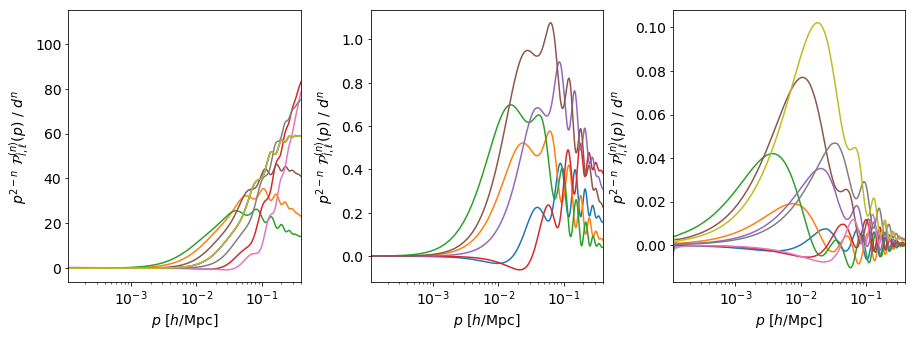

In [43]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
plt.subplots_adjust(wspace=0.3)

for i in range(3): 
    for j in range(3):
        ax[0].plot(p_arr, p_arr**2*P_0lmp[i,j])

for i in range(2): 
    for j in range(3):
        ax[1].plot(p_arr, p_arr*P_1lmp[i,j] / d)

for i in range(3): 
    for j in range(3):
        ax[2].plot(p_arr, P_2lmp[i,j] / d**2)
        
for n in range(3):
    ax[n].set_ylabel(r'$p^{2-n}\  \mathcal{P}^{(n)}_{l,\ell}(p) \ / \  d^n$')
    ax[n].set_xlabel(r'$p \ [h/{\rm Mpc}]$')
    ax[n].set_xlim(1.1e-4, 4e-1)
    ax[n].set_xscale('log')

$P_l(k), n=0$:  

In [44]:
pp = np.einsum('l,k->lk', beta_l, ip11(p_arr))
pk = np.einsum('l,k->lk', beta_l, ip11(k_arr))
pk_c = np.einsum('p,lmkp,mp->lk', p_arr**2*deltap, np.real(Wlm_c[0][::2,::2]), pp)
pk_cic = np.einsum('p,lmkp,mp->lk', p_arr**2*deltap, np.real(Wlm_cic[0][::2,::2]), pp)
pk_bin = np.einsum('p,lmkp,mp->lk', p_arr**2*deltap, np.real(Wlm_cic_bin[0][::2,::2]), pp)

$P_l(k), n=1,2$:  

In [45]:
pk_n1 = np.einsum('p,lmkp,mn,mnp->lk', deltap*p_arr**1, np.imag(Wlm_cic[1][::2,1::2]), alpha_1lm, P_1lmp)
pk_n2 = np.einsum('p,lmkp,mn,mnp->lk', deltap*p_arr**0, np.real(Wlm_cic[2][::2,::2]), alpha_2lm, P_2lmp)

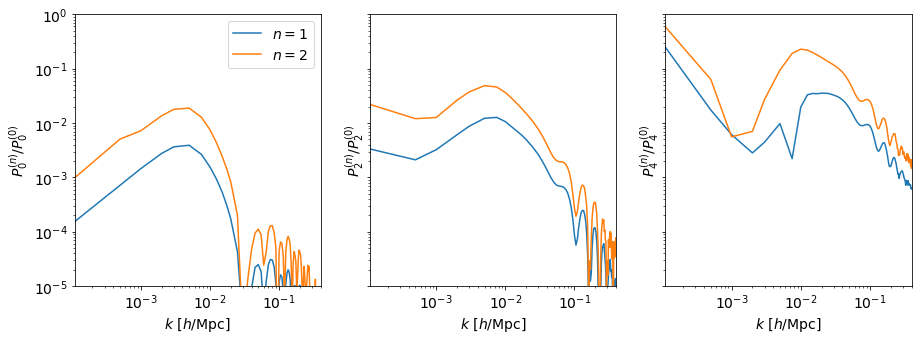

In [25]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
plt.subplots_adjust(wspace=0.2)

for i,l in enumerate([0,2,4]): 
    ax[i].plot(k_arr, np.abs(pk_n1[i]/pk[i]), label=r'$n=1$')
    ax[i].plot(k_arr, np.abs(pk_n2[i]/pk[i]), label=r'$n=2$')
    ax[i].set_xlabel(r'$k \ [h/{\rm Mpc}]$')
    ax[i].set_xlim(1.1e-4, 4e-1)
    ax[i].set_xscale('log')
    ax[i].set_ylabel(r'$P^{(n)}_%s / P^{(0)}_%s$' % (2*i, 2*i))
    ax[i].set_ylim(1e-5, 1e0)
    ax[i].set_yscale('log')
    
ax[0].legend()
plt.show()

BOSS error bars

In [26]:
def get_cov_ps(kk, ipklin, Vs=3.e9, nbar=2.e-4, b1=b1, f1=f1):
    dk = np.concatenate((kk[1:]-kk[:-1], [kk[-1]-kk[-2]])) # this is true for k >> kf
    Nmode = 4 * np.pi * kk**2 * dk * (Vs / (2*np.pi)**3)
    mu_arr = np.linspace(0., 1., 200)
    k_mesh, mu_mesh = np.meshgrid(kk, mu_arr, indexing='ij')
    legendre_mesh = np.array([legendre(2*l)(mu_mesh) for l in range(3)])
    legendre_ell_mesh = np.array([(2*(2*l)+1)*legendre(2*l)(mu_mesh) for l in range(3)])
    pkmu_mesh = (b1 + f1 * mu_mesh**2)**2 * ipklin(k_mesh)
    integrand_mu_mesh = np.einsum('k,km,lkm,pkm->lpkm', 1./Nmode, (pkmu_mesh + 1/nbar)**2, 
                                  legendre_ell_mesh, legendre_ell_mesh)
    cov_diagonal = 2 * np.trapz(integrand_mu_mesh, x=mu_arr, axis=-1)
    return np.block([[np.diag(cov_diagonal[i,j]) for i in range(3)] for j in range(3)]) 

cov_th_p = get_cov_ps(k_data, ip11)
err_th_p = np.sqrt(np.diag(cov_th_p)).reshape(3,-1)

Summary of geometrical effects: window (win), integral constraints (ic), wide-angle up to $n=2$ (wa), and binning (bin)

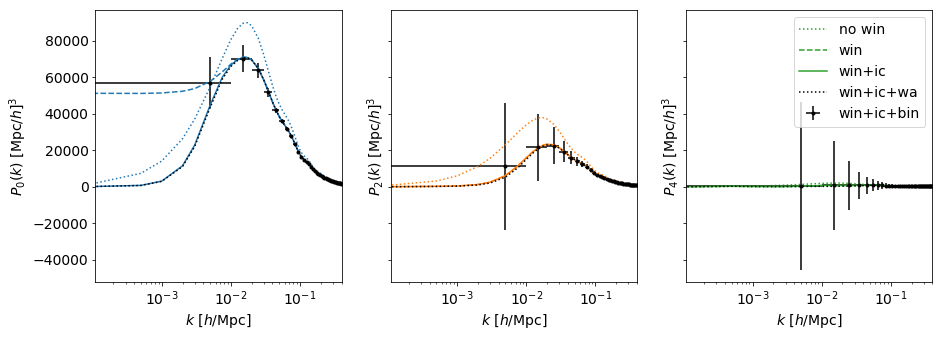

In [54]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
plt.subplots_adjust(wspace=0.2)

for i in range(3): 
    ax[i].plot(k_arr, pk[i], 'C%s:' % i, label='no win')
    ax[i].plot(k_arr, pk_c[i], 'C%s--' % i, label='win')
    ax[i].plot(k_arr, pk_cic[i], 'C%s' % i, label='win+ic')
    ax[i].plot(k_arr, pk_cic[i]+pk_n1[i]+pk_n2[i], 'k:', label=r'win+ic+wa')
    ax[i].errorbar(k_data, pk_bin[i], xerr=0.005, yerr=err_th_p[i], color='k', fmt='.', label='win+ic+bin')
    ax[i].set_xlabel(r'$k \ [h/{\rm Mpc}]$')
    ax[i].set_ylabel(r"$P_%s(k) \ [{\rm Mpc}/h]^{3}$" % (2*i))
    ax[i].set_xlim(1.1e-4, 4e-1)
    ax[i].set_xscale('log')
ax[2].legend()
plt.show()